## Version Info
LGBM Baseline without any analysis: LB = 0.22

In [199]:
import os
import shutil
import subprocess
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None


def download_dataset_from_kaggle(user, dataset, directory):
    command = "kaggle datasets download -d "
    filepath = directory / (dataset + ".zip")

    if not filepath.is_file():
        subprocess.run((command + user + "/" + dataset).split())
        filepath.parent.mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(dataset + ".zip", "data")
        shutil.move(dataset + ".zip", "data")


def download_competition_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


In [200]:
competition = "icr-identify-age-related-conditions"

if not ON_KAGGLE:
    download_competition_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
    greeks_path = "data/greeks.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"
    greeks_path = f"/kaggle/input/{competition}/greeks.csv"

train = pd.read_csv(train_path, index_col="Id")
test = pd.read_csv(test_path, index_col="Id")
greeks = pd.read_csv(greeks_path, index_col="Id")


In [201]:
train.head()


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [202]:
preprocess = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            StandardScaler(),
        ),
        make_column_selector(dtype_include=np.number),
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown="infrequent_if_exist"),
        ),
        make_column_selector(dtype_include=object),
    ),
    verbose_feature_names_out=False,
)


In [203]:
def neg_balanced_log_loss(y_true, y_pred, **kwargs):
    N0, N1 = np.bincount(y_true)

    y0 = np.where(y_true == 0, 1, 0)
    y1 = np.where(y_true == 1, 1, 0)

    eps = kwargs.get("eps", 1e-15)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    p0 = np.log(1 - y_pred)
    p1 = np.log(y_pred)

    return (1 / N0 * np.sum(y0 * p0) + 1 / N1 * np.sum(y1 * p1)) * 0.5


In [204]:
def get_class_weights(y_true):
    N0, N1 = np.bincount(y_true)
    C0, C1 = np.unique(y_true)
    return {
        C0: len(y_true) / N0,
        C1: len(y_true) / N1,
    }


In [205]:
X = train.drop("Class", axis=1)
y = train.Class
class_weights = get_class_weights(y)

scores = -cross_val_score(
    make_pipeline(
        preprocess,
        LGBMClassifier(
            random_state=42,
            is_unbalance=True,
            class_weight="balanced",
            max_depth=2,
        ),
    ),
    X,
    y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=make_scorer(neg_balanced_log_loss, needs_proba=True),
    error_score="raise",  # type: ignore
    # fit_params={
    #     "randomforestclassifier__sample_weight": np.where(y == 0, w0, w1),
    # },
)
pd.Series(scores).describe()


count    5.000000
mean     0.262261
std      0.055029
min      0.225926
25%      0.237846
50%      0.240975
75%      0.246805
max      0.359751
dtype: float64

In [206]:
# np.random.seed(42)

N_BAGS = 10
N_FOLDS = 5

X = train.drop("Class", axis=1)
y = train.Class
w0, w1 = get_class_weights(y)

y_proba = np.zeros_like(y, dtype=np.float64)
classifiers = np.empty(N_BAGS, dtype=object)

skfold_seeds = np.random.randint(0, 19937, size=N_BAGS)
classifier_params = {
    "is_unbalance": True,
    "class_weight": "balanced",
    "max_depth": 2,
}

for bag in range(N_BAGS):
    seed = skfold_seeds[bag]
    skfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    current_classifier = LGBMClassifier(random_state=seed, **classifier_params)
    classifiers[bag] = current_classifier

    for fold, (train_ids, valid_ids) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

        X_train = preprocess.fit_transform(X_train)
        X_valid = preprocess.transform(X_valid)

        current_classifier.fit(X_train, y_train)
        y_proba[valid_ids] += current_classifier.predict_proba(X_valid)[:, 1]

y_proba_rescaled = y_proba / N_BAGS
print("Balanced Log Loss:", f"{-neg_balanced_log_loss(y, y_proba_rescaled):.5f}")


Balanced Log Loss: 0.24672


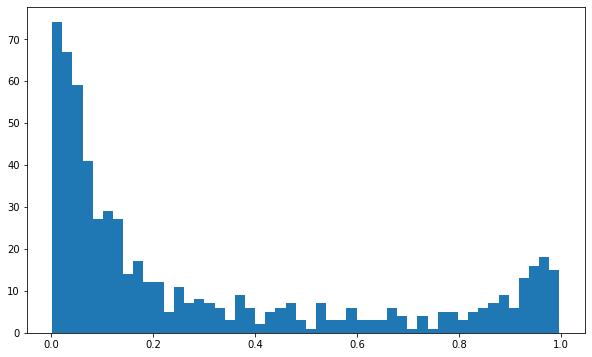

In [207]:
plt.figure(figsize=(10, 6))
plt.hist(y_proba_rescaled, bins=50)
plt.show()

In [208]:
test_ids = test.index

X_train = preprocess.fit_transform(X)
y_train = y

X_test = preprocess.transform(test)
y_test = np.zeros_like(test_ids)

for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_test += classifier.predict_proba(X_test)[:, 1]

y_test_rescaled = y_test / N_BAGS


In [209]:
submission = pd.DataFrame(
    {
        "Id": test_ids,
        "class_0": 1 - y_test_rescaled,
        "class_1": y_test_rescaled,
    }
).set_index("Id")

submission.to_csv("submission.csv")
submission.head()


,class_0,class_1
Id,,
00eed32682bb,0.548685,0.451315
010ebe33f668,0.548685,0.451315
02fa521e1838,0.548685,0.451315
040e15f562a2,0.548685,0.451315
046e85c7cc7f,0.548685,0.451315
